
# Churn prediction - Kaggle competition
##### [Go to project Github repository](https://github.com/Olks/churn_prediction)
####  
This a an exploratory analysis and prediction with XGBoost for Kaggle competition:

["WSDM - KKBox's Churn Prediction Challenge
Can you predict when subscribers will churn?"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/)

The competition is over but you can still download the data, read notebooks of participants and learn!
<br>And then submit your prediction to see how well your model perform. 


#### Overview of the task
The goal of the competition is to predict if the user of the music streaming service will renew the subscription. Usually the subscription lasts 30 days and can be automatically renewed.
<br>Churn definition (in data description on Kaggle)
>The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.


## Summary of my best solution
<b>This solution scored 0.11637 on Public Leaderboard what gives it 41th place (best 8%)</b>   

<br>
I've used <b>PySpark</b> to filter user_logs.csv (file is too big to lead into memory).
<br>
<br>
Best model <b>features</b>:

-  <b>last_is_auto_renew</b>: (boolean) if last subscription will be renewed automatically,
-  <b>cancel_sum_4weeks</b>: number of cancelation during the last 4 weeks, 
-  <b>days_from_start</b>: number of days from the first transaction,
-  <b>last_payment_plan_days</b>: length of the current subscription in days,
-  <b>last_month_logs_num</b>: number of active days during last 4 weeks,
-  <b>num_100_sum</b>: number of transactions during the last transaction day.
 
<br>
<b>Algorithm</b> and <b>parameters</b>:

 - XGBoost
 - max_depth=3
 - scale_pos_weight=0.8
 - learning_rate=0.1

### Data overview
Unbalanced target - 3:97

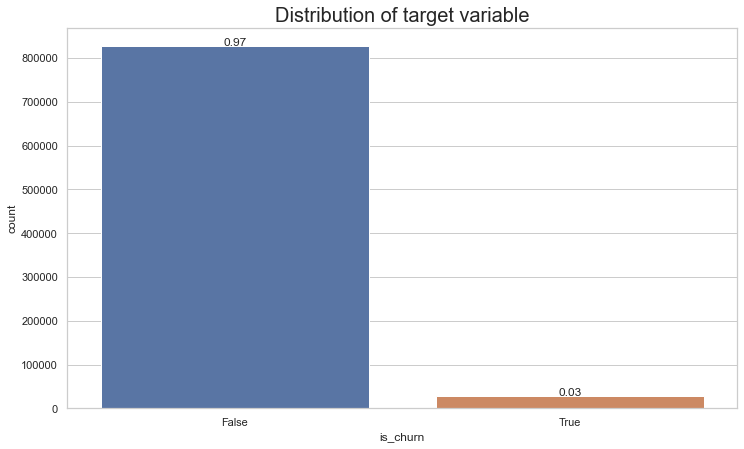

In [96]:
def plot_bars(data, x, hue=None, title=None):
    if not title:
        title = x
    ax = sns.countplot(x=x, hue=hue, data=data)
    ax.set_title(title, size=20)
    total=all_my_train_features_feb.shape[0]
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/total),
                ha="center") 
        
plot_bars(all_my_train_features_feb, "is_churn", title="Distribution of target variable")

### Important features

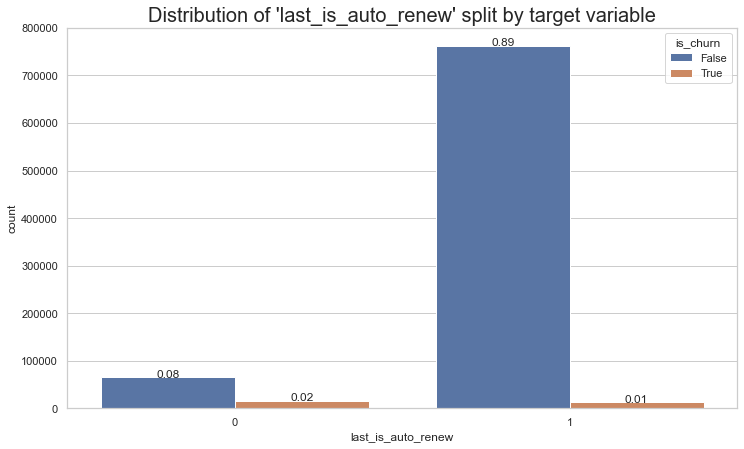

In [99]:
plot_bars(all_my_train_features_feb, 
          "last_is_auto_renew", 
          hue="is_churn", 
          title=r"Distribution of 'last_is_auto_renew' split by target variable")

In [100]:
print(f"{0.01/0.90: 0.2%} of users whose subscription is automatically renewed churn")
print(f"{0.02/0.08: 0.2%} of users whose subscription is NOT automatically renewed churn")

 1.11% of users whose subscription is automatically renewed churn
 25.00% of users whose subscription is NOT automatically renewed churn


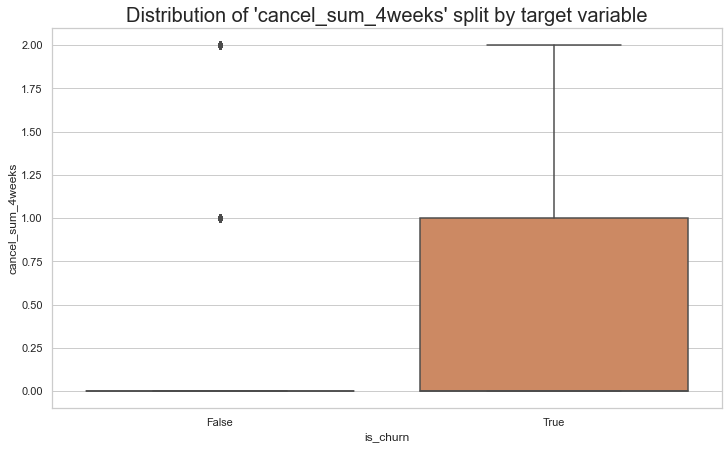

In [106]:
ax = sns.boxplot(x="is_churn", y="cancel_sum_4weeks", data=all_my_train_features_feb)
ax.set_title("Distribution of 'cancel_sum_4weeks' split by target variable", size=20);

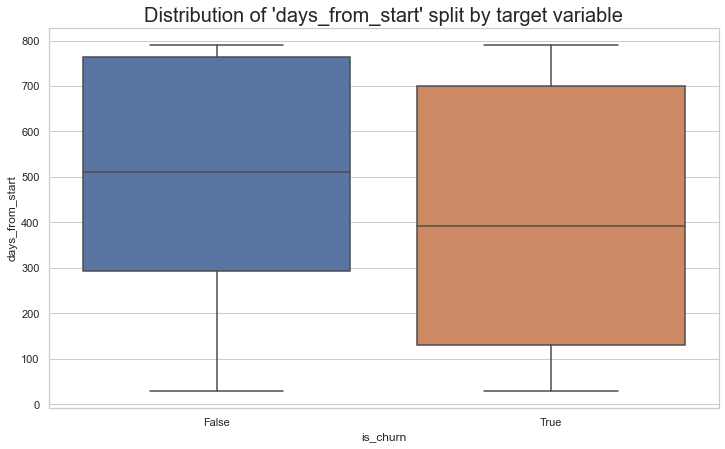

In [107]:
ax = sns.boxplot(x="is_churn", y="days_from_start", data=all_my_train_features_feb)
ax.set_title("Distribution of 'days_from_start' split by target variable", size=20);

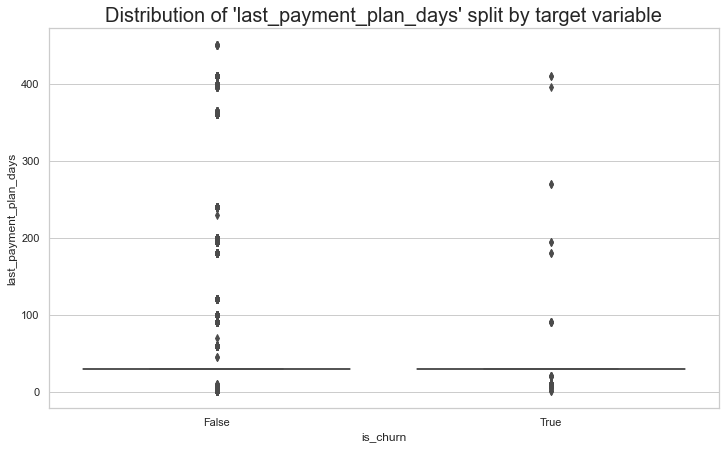

In [111]:
ax = sns.boxplot(x="is_churn", y="last_payment_plan_days", data=all_my_train_features_feb)
ax.set_title("Distribution of 'last_payment_plan_days' split by target variable", size=20);

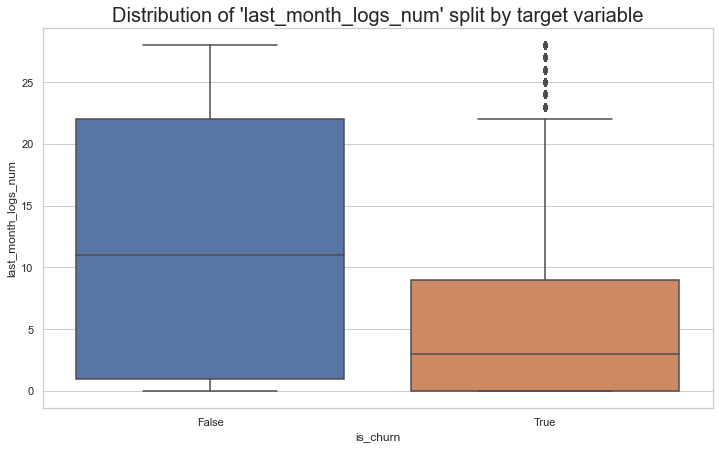

In [112]:
ax = sns.boxplot(x="is_churn", y="last_month_logs_num", data=all_my_train_features_feb)
ax.set_title("Distribution of 'last_month_logs_num' split by target variable", size=20);

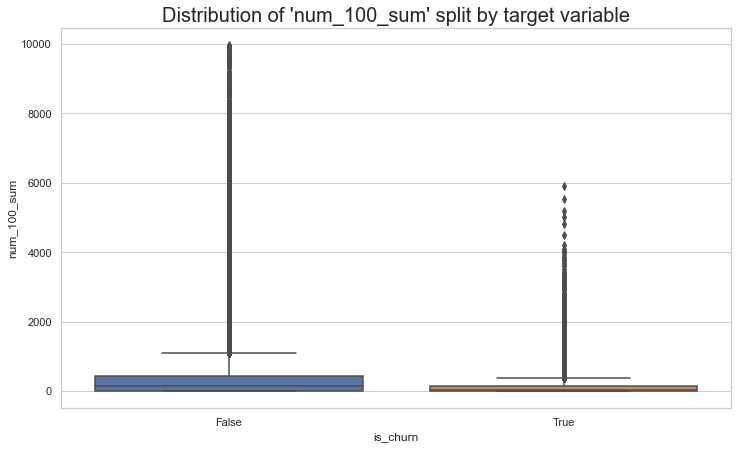

In [114]:
ax = sns.boxplot(x="is_churn", y="num_100_sum", 
        data=all_my_train_features_feb.loc[all_my_train_features_feb.num_100_sum<10000])
ax.set_title("Distribution of 'num_100_sum' split by target variable", size=20);

##   
##   
## My Solution

### Loading the data

The files set provided contains bigger files with data till the end of February 2017 and additional files ("v2" suffix) with update of March 2017.
<br>They are too big to load them all into python but we can concatenate some of them in GNU terminal (e.g. on Windows in Git Bash):
><code>cat transactions.csv > transactions_v3.csv; tail -n +2 transactions_v2.csv >> transactions_v3.csv </code>

Import libraries, helper functions and data files; details:  [Go to project Github repository](https://github.com/Olks/churn_prediction)

In [11]:
# Import libraries and helper functions
%run -i "helpers.py"

In [2]:
# Load data files
%run -i "files_loader.py"

In [3]:
# Let's check what we have defined after running helpers.py
%whos

Variable                              Type         Data/Info
------------------------------------------------------------
PROJECT_DIR                           str          C:\Users\Olks\Desktop\churn_prediction
calculate_last_subsciption_features   function     <function calculate_last_<...>es at 0x0000017266CBA510>
calculate_logs_features               function     <function calculate_logs_<...>es at 0x0000017269D88BF8>
calculate_transactional_features      function     <function calculate_trans<...>es at 0x0000017269D88B70>
get_labels                            function     <function get_labels at 0x0000017264BDC950>
join                                  function     <function join at 0x00000172622587B8>
members_v3_path                       str          C:\Users\Olks\Desktop\chu<...>prediction\members_v3.csv
pd                                    module       <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt                                   module       <module 'matplotli

#### Labels

There were a confusion over the way of calculating labels for users.
[Competition Forum](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/discussion/45991)
<br> I've tried 3 sources:
- calculated with my script in python,
- calculated with scala script provided by organisers,
- calculated with scala script provided by organisers extending filter for transaction date to one year,
- used train.csv file provided with the competition data,
- used train_v2.csv file provided with the competition data.

<b>Result: Training the model with the lables from "train.csv" gave significantly better results on Kaggle Leaderboard than all other lables.</b>


In [6]:
# Lebels alculated with my script in python 
# labels_january = get_labels(transactions_v3, "20170201")
# labels_february = get_labels(transactions_v3, "20170301")
# labels_january.to_pickle("labels_january.pkl")
# labels_february.to_pickle("labels_february.pkl")

labels_january = pd.read_pickle("labels_january.pkl")
labels_february = pd.read_pickle("labels_february.pkl")

In [49]:
# Labels calculated with scala script provided by organisers
# scala_labels_january = pd.read_csv("scala_labels_january.csv")
# scala_labels_february = pd.read_csv("scala_labels_february.csv")

In [4]:
# Labels calculated with scala script provided by organisers 
# extending filter for transaction date to one year -BETTER!
labels_january = pd.read_csv("scala_labels_january_one_month.csv")
labels_february = pd.read_csv("scala_labels_february_one_month.csv")

In [5]:
# Lables provided with the competition data
train = pd.read_csv("train.csv")
train_v2 = pd.read_csv("train_v2.csv")

### Exploration of the data

#### First data check: reading 1000 lines per file because they are too big read them all at once
- Later we can read selected columns or whole files by chunks

In [4]:
train = pd.read_csv(train_path, nrows=1000)
train_v2 = pd.read_csv(train_v2_path, nrows=1000)
user_logs = pd.read_csv(user_logs_path, nrows=1000) 
user_logs_v2 = pd.read_csv(user_logs_v2_path, nrows=1000)
sample_submission_zero = pd.read_csv(sample_submission_zero_path, nrows=1000)
sample_submission_v2 = pd.read_csv(sample_submission_v2_path, nrows=1000)
transactions = pd.read_csv(transactions_path, nrows=1000)
transactions_v2 = pd.read_csv(transactions_v2_path, nrows=1000)
transactions_v3 = pd.read_csv(transactions_v3_path, nrows=1000) 
members_v3 = pd.read_csv(members_v3_path, nrows=1000)

In [5]:
tables = {
    "train": train, 
    "train_v2": train_v2, 
    "user_logs": user_logs,
    "user_logs_v2": user_logs_v2, 
    "sample_submission_zero": sample_submission_zero, 
    "sample_submission_v2": sample_submission_v2,
    "transactions": transactions,
    "transactions_v2": transactions_v2,
    "transactions_v3": transactions_v3,
    "members_v3": members_v3
}

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
for table_name, table in tables.items():
    print("\n------------------------------------------------------")
    print(f"Table name: \"{table_name}\"")
    display(table.describe().transpose())
    display(table.dtypes.transpose())

### Basic Trasactional Features

The challenge winner, Bryian Gregory, gives a few tips in his article, <br>
**"Predicting Customer Churn: Extreme Gradient Boosting with Temporal Data"**
<br>
https://medium.com/@bryan.gregory1/predicting-customer-churn-extreme-gradient-boosting-with-temporal-data-332c0d9f32bf

He gives a hint that the features should be relative to a cutoff day. He calls it "Relative Refactoring Method".
<br> So we should transform the day of first transaction into the number of days from the first transaction.
<br> Only if days are "special" like holidays we could live them as exact days. We should not mix those approaches.
<br> Here, I'll calculate a few relative features, e.g.:
- **days_from_start** = Number of days from first transaction
<b><br><br>Full list of features below in the section 'Modeling with XGboost'.</b>

In [12]:
# filter only users that have lable and create features for them
transactions_jan = labels_january.merge(transactions_v3)
train_transactional_features_jan = calculate_transactional_features(transactions_jan, '20170201')
train_last_subsciption_features_jan = calculate_last_subsciption_features(transactions_jan, '20170201')
train_with_features_jan = train_transactional_features_jan.merge(
                                            train_last_subsciption_features_jan, on="msno")

In [13]:
transactions_feb = labels_february.merge(transactions_v3)
train_transactional_features_feb = calculate_transactional_features(transactions_feb, '20170301')
train_last_subsciption_features_feb = calculate_last_subsciption_features(transactions_feb, '20170301')
train_with_features_feb = train_transactional_features_feb.merge(
                                            train_last_subsciption_features_feb, on="msno")

In [14]:
transactions_mar = sample_submission_v2.merge(transactions_v3)
test_transactional_features_mar = calculate_transactional_features(transactions_mar, '20170401')
test_last_subsciption_features_mar = calculate_last_subsciption_features(transactions_mar, '20170401')
test_with_features_mar = test_transactional_features_mar.merge(
                                            test_last_subsciption_features_mar, on="msno")

In [15]:
train_with_features_jan = train_with_features_jan.merge(labels_january)
train_with_features_feb = train_with_features_feb.merge(labels_february)

### Logs features

Logs file is too big to load it into the computer memory.
Let's use pyspark to filter out monthly logs!
<br> 
<br> I've used this code to filter logs by month:

<code>
# Import pyspark modules and create spark context and session
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local", "First App")
my_spark = SparkSession.builder.getOrCreate()
</code><code>
# Read the file and add to catalog
file_path = user_logs_path
user_logs = my_spark.read.csv(file_path, header=True)
user_logs.show()
user_logs.createOrReplaceTempView("user_logs")
print(my_spark.catalog.listTables())
</code><code>
# Filter only logs from january and february and save them to csv
query_january = "SELECT* FROM user_logs WHERE date >= 20170101 AND date <= 20170131"
january_logs = my_spark.sql(query_january)
january_logs.coalesce(1).write.format('csv').save("january_logs", header='true')

query_february = "SELECT* FROM user_logs WHERE date >= 20170201 AND date <= 20170228"
february_logs = my_spark.sql(query_february)
february_logs.coalesce(1).write.format('csv').save("february_logs", header='true')

my_spark.stop()
</code>

In [18]:
january_logs_path = join(PROJECT_DIR, "january_logs.csv")
january_logs = pd.read_csv(january_logs_path)
january_last_user_log = calculate_logs_features(january_logs, "20170201")
del january_logs

In [19]:
february_logs_path = join(PROJECT_DIR, "february_logs.csv")
february_logs = pd.read_csv(february_logs_path)
february_last_user_log = calculate_logs_features(february_logs, "20170301")
del february_logs

In [20]:
march_logs_path = join(PROJECT_DIR, "user_logs_v2.csv")
march_logs = pd.read_csv(march_logs_path)
march_logs = march_logs.loc[march_logs.date >= 20170301]
march_last_user_log = calculate_logs_features(march_logs, "20170401")
del march_logs

In [21]:
all_my_train_features_jan = train_with_features_jan.merge(january_last_user_log, 
                                                          how="left", on="msno")

# assing a value 99 for users who did not logged in the last month
# max_value = all_my_train_features_jan["days_from_last_log"].max()
all_my_train_features_jan["days_from_last_log"] = \
        all_my_train_features_jan["days_from_last_log"].fillna(99)   #max_value+1
all_my_train_features_jan = all_my_train_features_jan.fillna(0)

In [22]:
all_my_train_features_feb = train_with_features_feb.merge(february_last_user_log, 
                                                          how="left", on="msno")

# assing a value 99 for users who did not logged in the last month
# max_value = all_my_train_features_feb["days_from_last_log"].max()
all_my_train_features_feb["days_from_last_log"] = \
        all_my_train_features_feb["days_from_last_log"].fillna(99)   #max_value+1
all_my_train_features_feb = all_my_train_features_feb.fillna(0)

In [25]:
all_my_test_features = test_with_features_mar.merge(march_last_user_log, how="left", on="msno")

# assing a value 99 for users who did not logged in the last month
# max_value = all_my_test_features["days_from_last_log"].max()
all_my_test_features["days_from_last_log"] = \
        all_my_test_features["days_from_last_log"].fillna(99)   #max_value+1
all_my_test_features = all_my_test_features.fillna(0)

### Additional features exploration

In [24]:
all_my_train_features_feb.describe()

,transactions_num,days_from_start,cancel_sum,actual_amount_paid_sum,cancel_sum_4weeks,last_payment_method_id,last_payment_plan_days,last_plan_list_price,last_actual_amount_paid,last_is_auto_renew,...,num_25_sum_2weeks,num_25_mean_2weeks,num_50_sum_2weeks,num_50_mean_2weeks,num_75_sum_2weeks,num_75_mean_2weeks,num_985_sum_2weeks,num_985_mean_2weeks,num_100_sum_2weeks,num_100_mean_2weeks
count,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,...,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000,856144.000000
mean,15.941857,497.172389,0.270860,2150.187586,0.031376,39.157546,30.685561,130.244350,129.921033,0.904626,...,35.264334,3.796839,8.650420,0.937124,5.486255,0.579952,6.244576,0.645577,172.272678,17.391229
std,8.189144,244.196115,0.570167,1283.820244,0.175006,3.433824,13.974196,64.653175,64.896487,0.293731,...,69.975818,6.655631,16.800542,1.699116,9.805770,0.931387,16.345373,1.395451,315.070692,26.628894
min,1.000000,29.000000,0.000000,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,288.000000,0.000000,1043.000000,0.000000,38.000000,30.000000,99.000000,99.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,508.000000,0.000000,1788.000000,0.000000,41.000000,30.000000,129.000000,129.000000,1.000000,...,10.000000,1.750000,3.000000,0.444444,2.000000,0.300000,2.000000,0.307692,62.000000,10.750000
75%,24.000000,764.000000,0.000000,3354.000000,0.000000,41.000000,30.000000,149.000000,149.000000,1.000000,...,42.000000,4.923077,11.000000,1.222222,7.000000,0.857143,8.000000,0.909091,216.000000,23.250000
max,72.000000,790.000000,11.000000,13006.000000,2.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,...,4898.000000,445.272727,1337.000000,111.416667,921.000000,106.500000,2894.000000,206.714286,21943.000000,4633.000000


In [26]:
all_my_test_features.describe()

,index,transactions_num,days_from_start,is_cancel,last_payment_method_id,last_payment_plan_days,last_plan_list_price,last_actual_amount_paid,last_is_auto_renew,last_transactions_num,...,num_25_mean,num_50_sum,num_50_mean,num_75_sum,num_75_mean,num_985_sum,num_985_mean,num_100_sum,num_100_mean,days_from_last_log
count,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,...,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000,907471.000000
mean,453735.000000,15.770538,503.267506,0.257721,38.942572,35.174317,149.140205,148.802903,0.881753,1.003132,...,4.285384,20.217150,1.044683,12.675413,0.631534,14.222308,0.686253,402.690464,18.751104,25.103464
std,261964.457402,8.880478,263.567874,0.564827,3.729406,38.349522,166.331364,166.470235,0.322901,0.162100,...,7.110854,35.743723,1.828910,20.755200,0.935977,36.992547,1.414554,703.863321,25.709556,40.419621
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,226867.500000,8.000000,272.000000,0.000000,38.000000,30.000000,99.000000,99.000000,1.000000,1.000000,...,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.500000,1.000000
50%,453735.000000,16.000000,523.000000,0.000000,41.000000,30.000000,129.000000,129.000000,1.000000,1.000000,...,2.400000,8.000000,0.600000,5.000000,0.416667,5.000000,0.421053,172.000000,12.888889,2.000000
75%,680602.500000,23.000000,791.000000,0.000000,41.000000,30.000000,149.000000,149.000000,1.000000,1.000000,...,5.500000,25.000000,1.350000,17.000000,0.892857,17.000000,0.931034,508.000000,24.375000,19.000000
max,907470.000000,73.000000,821.000000,21.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,41.000000,...,1710.866667,3163.000000,452.000000,1310.000000,157.000000,15164.000000,489.161290,57675.000000,2371.000000,99.000000


### Does churn depend on number of days from the first transaction?
- Churning user have a bit lower number of days that passed from the first transaction.

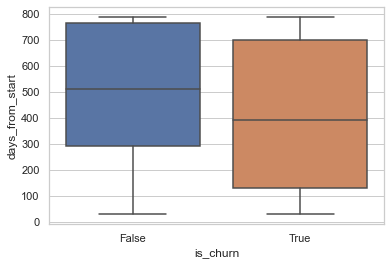

In [27]:
ax = sns.boxplot(x="is_churn", y="days_from_start", data=all_my_train_features_feb)

### Does churn depend on number of all transactions that user made?
- Yes, users who churn made a bit less transactions (this is correlated with the first variable)
- However, this feature has to be correlated with "days_from_start" and I will need to choose one of them. 

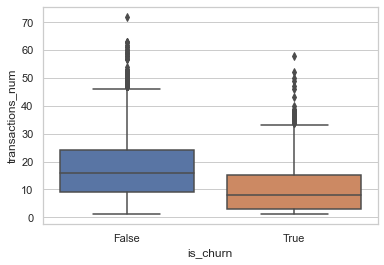

In [31]:
ax = sns.boxplot(x="is_churn", y="transactions_num", data=all_my_train_features_feb)

### Does churn depend on number of all cancelations that user made?
- Yes, users who churn made more cancelations.

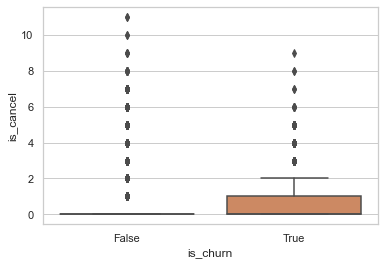

In [33]:
ax = sns.boxplot(x="is_churn", y="is_cancel", data=all_my_train_features_feb)

### Members data
Not all users are members and using the data will create a lot of missing values.
<br>But we can at least add boolean feature if the user is a member.

In [26]:
members = pd.read_csv(members_v3_path)
members["is_member"] = 1

In [27]:
members_feb = members.loc[members.registration_init_time <= 20170228]
all_my_train_features_feb = all_my_train_features_feb.merge(members_feb[["msno", "is_member"]], 
                                                            on="msno", how="left")
all_my_train_features_feb["is_member"] = all_my_train_features_feb["is_member"].fillna(0)

In [28]:
members_jan = members.loc[members.registration_init_time <= 20170131]
all_my_train_features_jan = all_my_train_features_jan.merge(members_jan[["msno", "is_member"]], 
                                                            on="msno", how="left")
all_my_train_features_jan["is_member"] = all_my_train_features_jan["is_member"].fillna(0)

In [29]:
members_mar = members.loc[members.registration_init_time <= 20170331]
all_my_test_features = all_my_test_features.merge(members_mar[["msno", "is_member"]], 
                                                            on="msno", how="left")
all_my_test_features["is_member"] = all_my_test_features["is_member"].fillna(0)

### Modeling with XGboost
Based on tutorial: <br>
["Using XGBoost in Python"](https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=9942305733&utm_adgroupid=100189364546&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034352&utm_targetid=aud-299261629574:dsa-929501846124&utm_loc_interest_ms=&utm_loc_physical_ms=9060640&gclid=Cj0KCQjw0YD4BRD2ARIsAHwmKVkoOKq4tg0ihd-a5jx70ZIDySVNt1e8bTrBYOOQkPIaLb5aElQY3FgaApotEALw_wcB)

1. Training and validating on one period:

In [ ]:
from sklearn.model_selection import train_test_split
random.seed(1)
train_set, test_set = train_test_split(all_my_train_features_feb, test_size=0.2)

2. Training and validating on separates periods 

In [138]:
train_set = all_my_train_features_feb
validation_set = all_my_train_features_jan
test_set = all_my_test_features

3. Training and validating on separates periods and using available lables from "train.csv"
(so trainign on february and validating on January - to use train.csv in model)

In [33]:
train = pd.read_csv("train.csv")
train_set = all_my_train_features_feb
train_set = train_set.drop(columns="is_churn").merge(train)

validation_set = all_my_train_features_jan
test_set = all_my_test_features

#### Let's calculate some more features

In [35]:
train_set["price_diff"] = train_set["last_plan_list_price"] - train_set["last_actual_amount_paid"]
validation_set["price_diff"]  = validation_set["last_plan_list_price"] - validation_set["last_actual_amount_paid"]
test_set["price_diff"]  = test_set["last_plan_list_price"] - test_set["last_actual_amount_paid"]

In [36]:
train_set["logs_diff"] = train_set["last_month_logs_num"] - train_set["date_count_2weeks"]
validation_set["logs_diff"]  = validation_set["last_month_logs_num"] - \
                                    validation_set["date_count_2weeks"]
test_set["logs_diff"]  = test_set["last_month_logs_num"] - test_set["date_count_2weeks"]

In [37]:
train_set["num_unq_mean_diff"] = train_set["num_unq_mean"] - train_set["num_unq_mean_2weeks"]
validation_set["num_unq_mean_diff"]  = validation_set["num_unq_mean"] - \
                                    validation_set["num_unq_mean_2weeks"]
test_set["num_unq_mean_diff"]  = test_set["num_unq_mean"] - test_set["num_unq_mean_2weeks"]

In [38]:
train_set["not_log_last_month"] = (train_set["days_from_last_log"] == 99).astype(int)
validation_set["not_log_last_month"]  = (validation_set["days_from_last_log"] == 99).astype(int)
test_set["not_log_last_month"]  = (test_set["days_from_last_log"] == 99).astype(int)

##### Unbalanced target data - it may be useful to adjust "scale_pos_weight" parameter

In [40]:
# scale_pos_weight [default=1] = sum(negative instances) / sum(positive instances)
train_set.groupby("is_churn").msno.count()

is_churn
0    817401
1     38684
Name: msno, dtype: int64

In [70]:
#XGBoost Model

random.seed(1)
features = [
    # memebrs features
#     "is_member",
    
#     # transactions features
#     "transactions_num", # worsen Kaggle score a lot!
    "cancel_sum_4weeks",
#     "cancel_sum",
    "days_from_start", 
    "last_is_auto_renew", 
    "last_payment_plan_days",
#     "price_diff", # -
#     "last_plan_list_price",
#     "last_actual_amount_paid",
#     "actual_amount_paid_sum",
#     "last_transactions_num", # +
# #     "p_3", # very rare
# #     "p_6", # very rare
#     "p_8",
#     "p_10",
#     "p_11",
#     "p_12",
#     "p_13",
#     "p_14",
#     "p_15",
#     "p_16",
#     "p_17",
#     "p_18",
#     "p_19",
#     "p_20",
#     "p_21",
#     "p_22",
#     "p_23",
# #     "p_25", # very rare
#     "p_26",
#     "p_27",
#     "p_28",  
#     "p_29",
#     "p_30",
#     "p_31",
#     "p_32",
#     "p_33",
#     "p_34",
#     "p_35",
#     "p_36",
#     "p_37",
#     "p_38",
#     "p_39",
#     "p_40",
#     "p_41",
    
#     # logs features
#     "logs_diff",
#     "num_unq_mean_diff",
#     "not_log_last_month",
#     "num_unq_mean_diff",
    
#     "days_from_last_log", # -
    "last_month_logs_num", # +
#     "total_secs_sum",
#     "total_secs_mean",
#     "num_unq_sum",
#     "num_unq_mean",
#     "num_25_sum",
#     "num_25_mean",
#     "num_50_sum",
#     "num_50_mean",
#     "num_75_sum",
#     "num_75_mean",
#     "num_985_sum",
#     "num_985_mean",
    "num_100_sum",
#     "num_100_mean",
  
#     # 2 weeks logs stats 
#     "date_count_2weeks",
#     "total_secs_sum_2weeks",
#     "total_secs_mean_2weeks",
#     "num_unq_sum_2weeks",
#     "num_unq_mean_2weeks",
#     "num_25_sum_2weeks",
#     "num_25_mean_2weeks",
#     "num_50_sum_2weeks",
#     "num_50_mean_2weeks",
#     "num_75_sum_2weeks",
#     "num_75_mean_2weeks",
#     "num_985_sum_2weeks",
#     "num_985_mean_2weeks",
#     "num_100_sum_2weeks",
#     "num_100_mean_2weeks"
    ]
X_train, y_train = train_set[features], train_set["is_churn"]
X_validation, y_validation = validation_set[features], validation_set["is_churn"]

xgb_model = xgb.XGBClassifier(verbosity=1,
                              max_depth=3, 
                              learning_rate=0.1,
                              scale_pos_weight = 0.8,
                              objective= "binary:logistic",
                              n_jobs=-1).fit(X_train, y_train)

print("Accuracy of XGB classifier on training set: {:.2f}"
       .format(xgb_model.score(X_train, y_train)))
print("Accuracy of XGB classifier on validation set: {:.2f}"
       .format(xgb_model.score(X_validation[X_train.columns], y_validation)))

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on validation set: 0.98


### Log loss for train and test set

In [71]:
from sklearn.metrics import log_loss
# log_loss(y_true, y_pred)

prediction_validation = xgb_model.predict_proba(X_validation[features])
prediction_train = xgb_model.predict_proba(X_train[features])
y_pred_validation = pd.DataFrame(prediction_validation).loc[:,1]
y_pred_train = pd.DataFrame(prediction_train).loc[:,1]
y_true_validation = y_validation
y_true_train = y_train

print("The lower log loss the better")
print(f"Validation set log loss: {log_loss(y_true_validation, y_pred_validation, normalize=True)}")
print(f"Train set log loss: {log_loss(y_true_train, y_pred_train, normalize=True)}")

The lower log loss the better
Validation set log loss: 0.07402163864521367
Train set log loss: 0.08140877907088333


In [ ]:
# max_depth=3, 
# learning_rate=0.1,
# scale_pos_weight = 0.8

# only "last_is_auto_renew",
Validation set log loss: 0.13098375307912818
Train set log loss: 0.15461264345138812
    
# "last_is_auto_renew" + "cancel_sum_4weeks"
Validation set log loss: 0.10324516501022737
Train set log loss: 0.10238881721483238
    
# "last_is_auto_renew" + "cancel_sum_4weeks" +  "last_payment_plan_days"
Validation set log loss: 0.10140033683802978
Train set log loss: 0.10183932052018661

# "last_is_auto_renew" + "cancel_sum_4weeks" +  "last_payment_plan_days" + "last_month_logs_num"
Validation set log loss: 0.07499458503825825
Train set log loss: 0.08435202898528919
    
# "last_is_auto_renew" + "cancel_sum_4weeks" +  "last_payment_plan_days" + "last_month_logs_num"
# "num_100_sum"
Validation set log loss: 0.07492322929117473
Train set log loss: 0.08425192502936533

# "last_is_auto_renew" + "cancel_sum_4weeks" +  "last_payment_plan_days" + "last_month_logs_num"
# "num_100_sum" + "transactions_num"
Validation set log loss: 0.07183727173957707
Train set log loss: 0.07863239886565912
# worsen Kaggle score a lot!!!

# the BEST !!! 
# "last_is_auto_renew" + "cancel_sum_4weeks" +  "last_payment_plan_days" + "last_month_logs_num"
# "num_100_sum" + "days_from_start"
Validation set log loss: 0.07402163864521367
Train set log loss: 0.08140877907088333
    
# other potentially good: "num_unq_mean", "date_count_2weeks"

##### !! Changing just lables in training set (using those from train.csv) increase the score on the Leader Board a lot !!
Looks like they are correct one.
<br>But we cannot produce more for different time periods with scala script (or some other way.
<br>So we have to use only users with subscription expiring in February. 

### Features importance
- We need to remember that there are many types of feature importance: 'weight', 'gain', 'cover',
- Default: ‘weight’: the number of times a feature is used to split the data across all trees. It may be lower for features with lower cardinality (like True/False features, so our "last_is_auto_renew"),
- ‘gain’: the average gain across all splits the feature is used in.

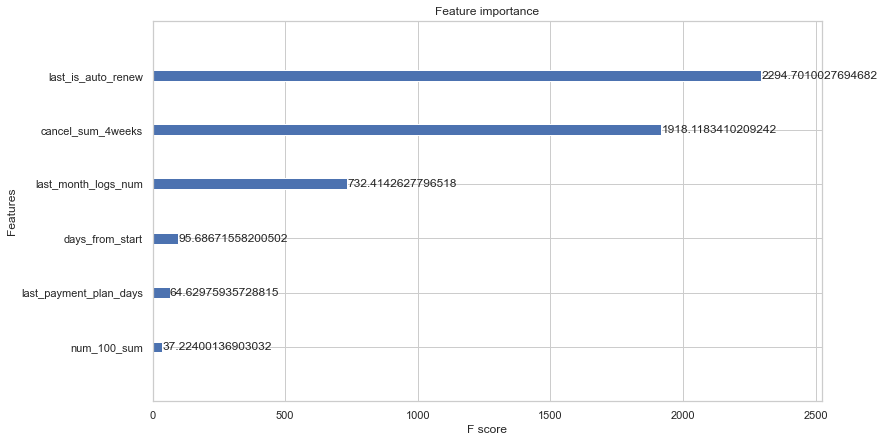

In [77]:
xgb.plot_importance(xgb_model, importance_type="gain")
plt.rcParams['figure.figsize'] = [12, 7]
plt.show()

In [73]:
submission = xgb_model.predict_proba(test_set[features])

In [74]:
submission_int = xgb_model.predict(test_set[features])

In [75]:
final_submission = pd.DataFrame({"msno": test_set.msno.reset_index(drop=True), 
                                 "is_churn": pd.DataFrame(submission).loc[:,1]})

In [76]:
final_submission.to_csv("submission_41.csv", index=False)

###### Train set log loss < Test set log loss  => Overfitting

#### Ideas to improve:
  - create more features and test one by one,
  - add different periods - maybe there is seasonality?,
  - remember to adjust parameters with new features,
  - with many features try increasing max_depth
   (if overfitting: decrease max_depth back a bit)  